# Report Without Ground Truth v1.0

## Input prameters

In [5]:
# %cd /data/mutect2/data_simulation/100x/170469/check_reporrt/

/data/mutect2/data_simulation/100x/170469/check_reporrt


In [7]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics_unfiltered = parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics_unfiltered.h5')
no_gt_statistics_filtered = parser.get('NOGTReport', 'filtered_h5_statistics', fallback='no_gt_statistics_filtered.h5')
is_somatic = parser.get('NOGTReport', 'is_somatic', fallback=False)
filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')


prmNames=['run_id',
          'h5_statistics', 'filtered_h5_statistics','is_somatic','filtered_vcf','interval_list'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)
    
prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf

,value
run_id,functator_report
h5_statistics,/data/mutect2/data_simulation/100x/170469/chec...
filtered_h5_statistics,/data/mutect2/data_simulation/100x/170469/chec...
is_somatic,true
filtered_vcf,/data/mutect2/data_simulation/100x/170469/chec...
interval_list,/data/wgs_calling_regions.hg38.interval_list


In [11]:
# !gsutil cp gs://runs-data/cromwell-execution/SomaticMutationsPipeline/8495b473-f120-4f22-9fca-cac3c1a2a010/call-FilteredNoGTStatistics/no_gt_statistics_filtered.h5 /data/mutect2/data_simulation/100x/170469/check_reporrt/
# !gsutil cp gs://runs-data/cromwell-execution/SomaticMutationsPipeline/8495b473-f120-4f22-9fca-cac3c1a2a010/call-UnfilteredNoGTStatistics/no_gt_statistics_unfiltered.h5 /data/mutect2/data_simulation/100x/170469/check_reporrt/
# !gsutil cp gs://runs-data/cromwell-execution/SomaticMutationsPipeline/8495b473-f120-4f22-9fca-cac3c1a2a010/call-AnnotateVCF_AF/functator_report.annotated.AF.vcf.gz /data/mutect2/data_simulation/100x/170469/check_reporrt/
# !gsutil cp gs://runs-data/cromwell-execution/SomaticMutationsPipeline/8495b473-f120-4f22-9fca-cac3c1a2a010/call-AnnotateVCF_AF/functator_report.annotated.AF.vcf.gz.tbi /data/mutect2/data_simulation/100x/170469/check_reporrt/  
# import os
# import sys
# home=os.environ['HOME']
# sys.path.append('/home/ubuntu/proj1/VariantCalling/src/')
# from python.utils import revcomp
# import python.vcftools as vcftools
# import python.pipelines.vcf_pipeline_utils as vcf_pipeline_utils
# no_gt_statistics_unfiltered = '/data/mutect2/data_simulation/100x/170469/check_reporrt/no_gt_statistics_unfiltered.h5'
# no_gt_statistics_filtered = '/data/mutect2/data_simulation/100x/170469/check_reporrt/no_gt_statistics_filtered.h5'
# filtered_vcf = '/data/mutect2/data_simulation/100x/170469/check_reporrt/functator_report.annotated.AF.vcf.gz'
# interval_list = '/data/mutect2/data_simulation/100x/170469/check_reporrt/wgs_calling_regions.hg38.interval_list'
# ref_fasta = '/data/Homo_sapiens_assembly38.fasta'
# ref_fasta_dict = '/data/Homo_sapiens_assembly38.fasta.dict'
# is_somatic = True

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D

home=os.environ['HOME']
sys.path.append('/VariantCalling/src/')
from python.utils import revcomp
import python.vcftools as vcftools
import python.pipelines.vcf_pipeline_utils as vcf_pipeline_utils

In [13]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

In [14]:

af_hist = pd.read_hdf(no_gt_statistics_unfiltered,'af_hist')
ins_del_hete = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_hete')
ins_del_homo = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_homo')
motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')

filtered_af_hist = pd.read_hdf(no_gt_statistics_filtered,'af_hist')
filtered_ins_del_hete = pd.read_hdf(no_gt_statistics_filtered,'ins_del_hete')
filtered_ins_del_homo = pd.read_hdf(no_gt_statistics_filtered,'ins_del_homo')
filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')
#eval
CompOverlap = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CompOverlap')
CountVariants = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CountVariants')
TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_unfiltered,'eval_TiTvVariantEvaluator')
IndelLengthHistogram = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelLengthHistogram')
IndelSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelSummary')
MetricsCollection = pd.read_hdf(no_gt_statistics_unfiltered,'eval_MetricsCollection')
ValidationReport = pd.read_hdf(no_gt_statistics_unfiltered,'eval_ValidationReport')
VariantSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_VariantSummary')

filtered_CompOverlap = pd.read_hdf(no_gt_statistics_filtered,'eval_CompOverlap')
filtered_CountVariants = pd.read_hdf(no_gt_statistics_filtered,'eval_CountVariants')
filtered_TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_filtered,'eval_TiTvVariantEvaluator')
filtered_IndelLengthHistogram = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelLengthHistogram')
filtered_IndelSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelSummary')
filtered_MetricsCollection = pd.read_hdf(no_gt_statistics_filtered,'eval_MetricsCollection')
filtered_ValidationReport = pd.read_hdf(no_gt_statistics_filtered,'eval_ValidationReport')
filtered_VariantSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_VariantSummary')

# Variants Statistics

In [15]:
CompOverlap = CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
CompOverlap.columns = pd.Series(CompOverlap.iloc[0])
CompOverlap = CompOverlap[1::].loc[["nEvalVariants"]]

filtered_CompOverlap = filtered_CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_CompOverlap.columns = pd.Series(filtered_CompOverlap.iloc[0])
filtered_CompOverlap = filtered_CompOverlap[1::].loc[["nEvalVariants"]]

In [16]:
CountVariants = CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
CountVariants.columns = pd.Series(CountVariants.iloc[0])
CountVariants = CountVariants[1::].loc[["nDeletions","nInsertions","nSNPs"]]

filtered_CountVariants = filtered_CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_CountVariants.columns = pd.Series(filtered_CountVariants.iloc[0])
filtered_CountVariants = filtered_CountVariants[1::].loc[["nDeletions","nInsertions","nSNPs"]]

In [17]:
TiTvVariantEvaluator = TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
TiTvVariantEvaluator.columns = pd.Series(TiTvVariantEvaluator.iloc[0])
TiTvVariantEvaluator = TiTvVariantEvaluator[1::].loc[["nTi","nTv","TiTvRatioStandard"]]

filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_TiTvVariantEvaluator.columns = pd.Series(filtered_TiTvVariantEvaluator.iloc[0])
filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator[1::].loc[["nTi","nTv","TiTvRatioStandard"]]

In [18]:
IndelSummary = IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
IndelSummary.columns = pd.Series(IndelSummary.iloc[0])
IndelSummary = IndelSummary[1::].loc[[
                       "SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate"]]

filtered_IndelSummary = filtered_IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_IndelSummary.columns = pd.Series(filtered_IndelSummary.iloc[0])
filtered_IndelSummary = filtered_IndelSummary[1::].loc[[
                       "SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate"]]



In [19]:
unfiltered = pd.concat([CompOverlap, CountVariants, TiTvVariantEvaluator, IndelSummary], axis=0)
filtered = pd.concat([filtered_CompOverlap, filtered_CountVariants, filtered_TiTvVariantEvaluator, filtered_IndelSummary], axis=0)

    
merged_df = pd.concat([unfiltered, filtered], axis=1, keys=["unfiltered","filtered"])

if is_somatic:
    merged_df = merged_df.drop(["SNP_het_to_hom_ratio","indel_het_to_hom_ratio"], axis=0)

merged_df

unfiltered                   filtered                 
Novelty                   all    known    novel      all    known   novel
nEvalVariants         6595481  3917816  2677665  3895791  3621772  274019
nDeletions             900430   212585   687845   203194   154847   48347
nInsertions           1253324   191845  1061479   194868   139953   54915
nSNPs                 4431518  3508224   923294  3489618  3322740  166878
nTi                   2702316  2361997   340319  2331683  2246149   85534
nTv                   1721286  1140503   580783  1151139  1071619   79520
TiTvRatioStandard        2.00     2.05     2.00     2.00     2.07    2.00
SNP_to_indel_ratio       2.05     8.47     0.53     8.57    10.97    1.61
indel_novelty_rate      80.86     0.00   100.00    25.66     0.00  100.00


<ul>
<li><b>nEvalVariants</b>- the number of variants <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nInsertions</b>- the number of variants determined to be insertions <br></li>
<li><b>nSNPs</b>- the number of variants determined to be single-nucleotide polymorphisms <br></li>
<li><b>nTi</b>- number of transition variants (A↔G or T↔C) <br></li>
<li><b>nTv</b>- number of transversion variants (A↔T or G↔C) <br></li>
<li><b>SNP_to_indel_ratio</b>- n_SNPs divided by n_indels <br></li>
<li><b>indel_novelty_rate</b>- n_novel_indels divided by n_indels<br></li>
</ul>





In [20]:
from IPython.display import display, Markdown

if is_somatic:
    display(Markdown("""# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. \n
    """))

# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. 

    

In [33]:
def af_hist_graph(filtered_af_hist):
    nbins = 100
    bin_edges = pd.Series(np.linspace(0, 1, nbins))

    for group in filtered_af_hist.columns:

        #plt.hist(af_hist[group],bin_edges, alpha=0.5, label=group)
        plt.hist(filtered_af_hist[group],bin_edges, alpha=0.5, label=group)
        plt.legend(loc='upper right')
        plt.xlabel("Estimated allele fraction")
        plt.ylabel("# Variants")
    plt.show()

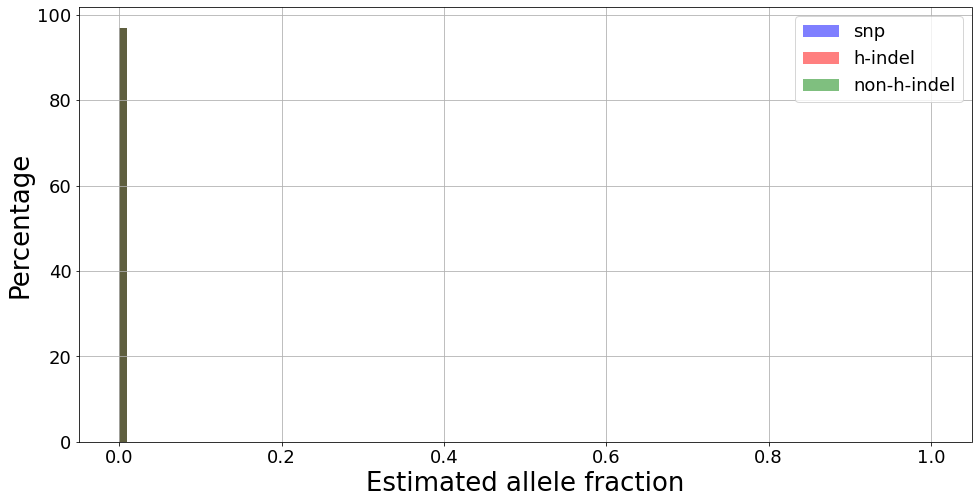

In [34]:
if is_somatic:
    af_hist_graph(filtered_af_hist)

# FDR Analysis

In [31]:
filtered_vcf_df = vcftools.get_vcf_df(filtered_vcf)

In [51]:
filtered_vcf_df.columns

Index(['chrom', 'pos', 'qual', 'ref', 'alleles', 'gt', 'pl', 'dp', 'ad', 'mq',
       'sor', 'af', 'filter', 'dp_r', 'dp_f', 'ad_r', 'ad_f', 'tlod',
       'strandq', 'fpr', 'tree_score', 'variant_type', 'db', 'indel'],
      dtype='object')

In [38]:
novel_vcf_df = filtered_vcf_df[filtered_vcf_df['db']!=True]
novel_pass_vcf_df = novel_vcf_df[novel_vcf_df['filter']=='PASS']

<!--  ## MetricsCollection -->

In [35]:
def FDR_graph(interval_size,fprs,pass_fps, ax=None,title = None,color='darkorange'):
    if ax is None:
        plt.figure()
        ax = plt.gca()
        ax.set_aspect('equal', 'datalim')
        #ax.set_aspect('equal', 'box')
        plt.axis('scaled')
        ax.grid()
    plt.sca(ax)
    
    fprs = pd.Series(fprs).dropna()
    pass_fprs = pd.Series(pass_fps).dropna()
    select_size = len(fprs)
    pass_select_size = len(pass_fprs)
    expected_below = fprs*interval_size
    pass_expected_below = pass_fprs*interval_size
    actual = np.arange(select_size)
    pass_actual = np.arange(pass_select_size)
    plt.xlabel('Expected # FP variants', fontsize=14)
    plt.ylabel('Observed #variants', fontsize=14)
    plt.title(title, fontsize=14)
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['axes.titlesize'] = 30
    params = {'legend.fontsize': 'x-large',
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}
    
    plt.loglog(expected_below, expected_below,color='royalblue')
    plt.loglog(expected_below, actual,'.',color='darkorange')
    plt.loglog(pass_expected_below, pass_actual,'.',color='green')
    plt.legend(labels=['Expected','All', 'Pass'])
    plt.rcParams.update(params)
    
    

In [25]:
# interval_size 10**6
interval_obj = vcf_pipeline_utils.IntervalFile(interval_list, ref_fasta, ref_fasta_dict)
interval_size = vcf_pipeline_utils.bed_file_length(interval_obj.as_bed_file())


FileNotFoundError: [Errno 2] No such file or directory: 'picard': 'picard'

In [40]:
# interval_size =10**9

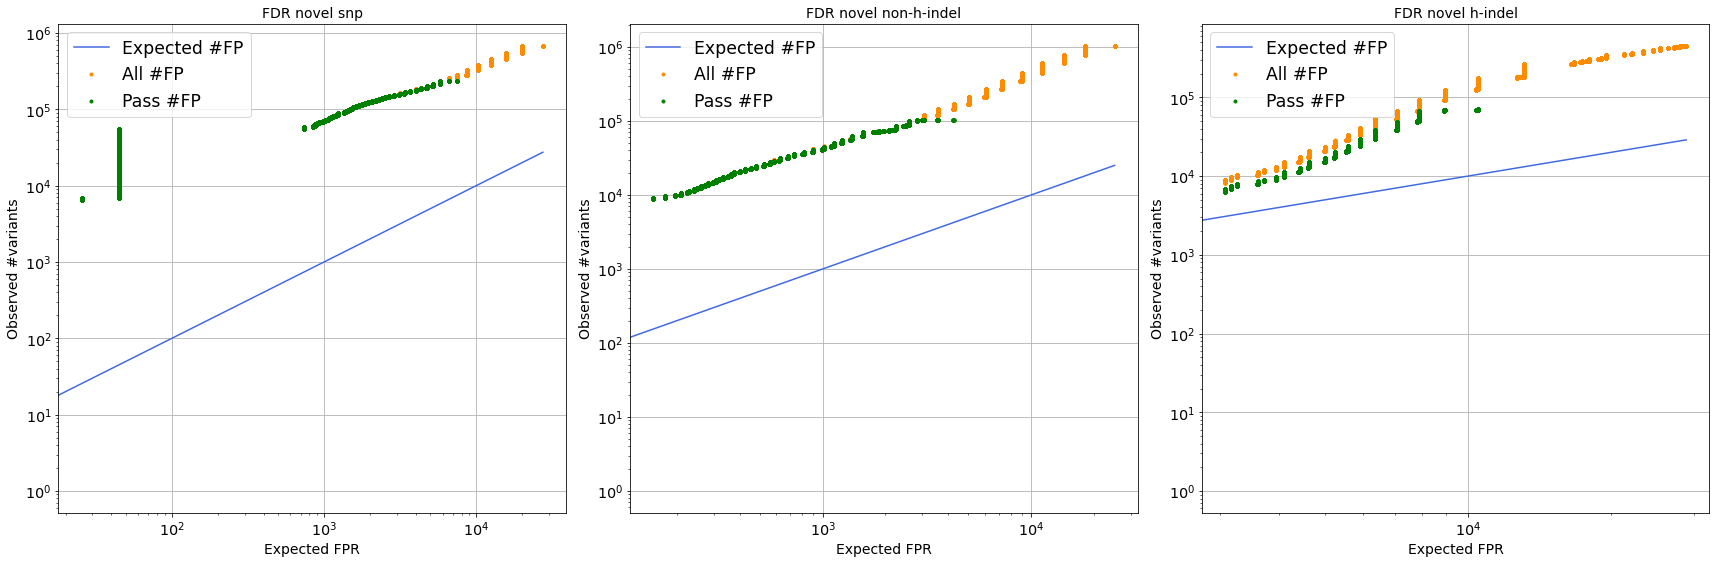

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
FDR_graph(interval_size,fprs,pass_fps,axes[0],'FDR novel snp')

fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
FDR_graph(interval_size,fprs,pass_fps,axes[1],'FDR novel non-h-indel')

fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
FDR_graph(interval_size,fprs,pass_fps,axes[2],'FDR novel h-indel')

fig.tight_layout()
plt.show()

# Snp statistics
Histogram for motif alterations

In [19]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None, title_prefix = ""):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    
    bbox_extra_artists = [
        plt.title(f"{title_prefix} {x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=24)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}->{alt}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]")
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



# plt.savefig(
#     outplot_motif0, dpi=dpi, bbox_inches="tight", bbox_extra_artists=bbox_extra_artists
# )

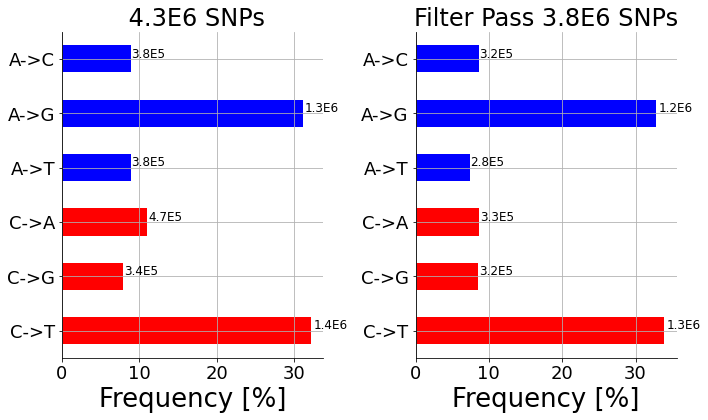

In [20]:
motifs_0 = motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))


plot_motifs0_bars(motifs_0, axes[0])

motifs_0 = filtered_motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]
plot_motifs0_bars(motifs_0, axes[1], "Filter Pass")

fig.tight_layout()

## Trinucleotide Heatmap
Heatmap for motif alterations in trinucleotide context

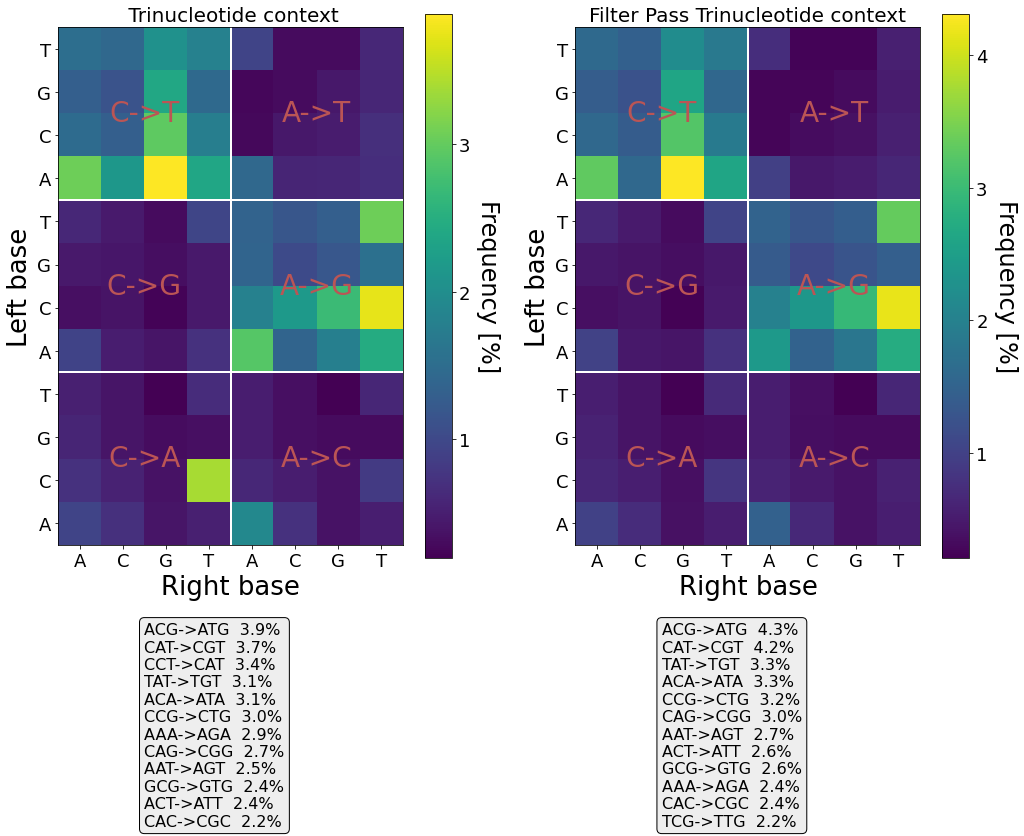

In [16]:
def plot_heatmap(motifs,ax=None, title_prefix = ""):
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title(f"{title_prefix} Trinucleotide context", fontsize=20)
    
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}->{y['alt_1']}",
            axis=1,
        )
    )
    
    table_str = "\n".join(
        (
            x["ref_motif"]
            + "->"
            + x["alt_motif"]
            + "  "
            + (x["size"]).apply(lambda x: f"{x:.1%}")
        )
        .loc[x.sort_values("size", ascending=False).head(12).index]
        .values
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)
    
    ax.text(
        0.25,
        -0.15,
        table_str,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
    )

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
            10 if (int(max(cbar.ax.get_yaxis().get_ticklocs()))-int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs())))>10) else 1))
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")

        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 10))

plot_heatmap(motifs, axes[0])
plot_heatmap(filtered_motifs, axes[1], "Filter Pass")

# INDEL statistics

## Distribution of indel lengths

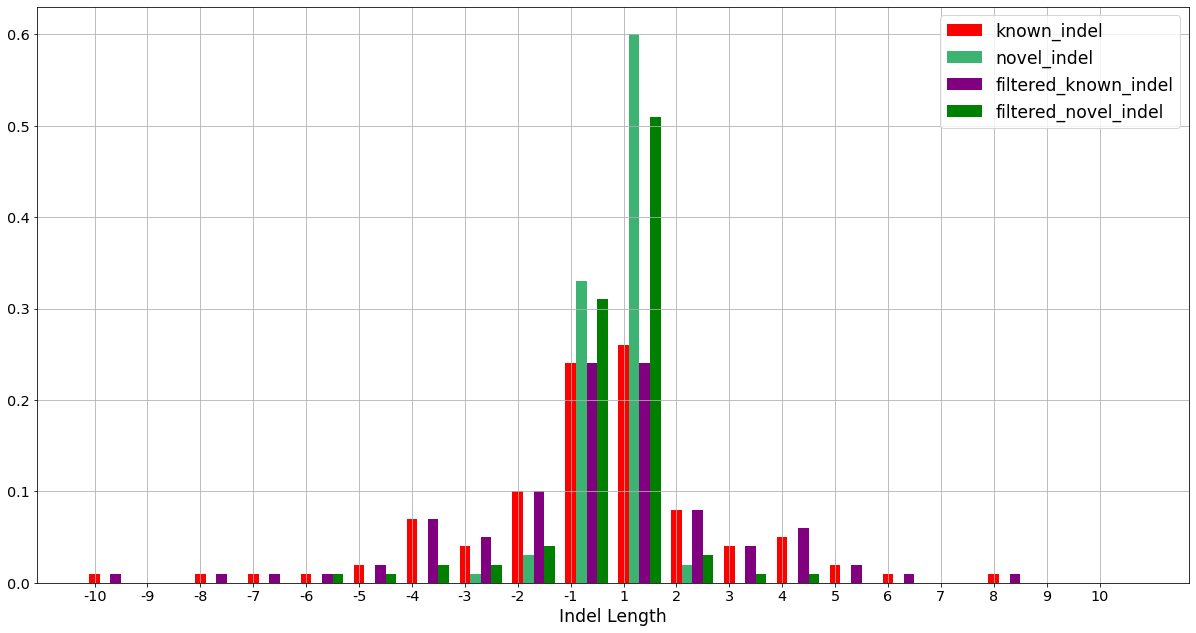

In [47]:
known_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
novel_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

filtered_known_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
filtered_novel_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

#filtered_novel_indel

def ins_del_hete_graph(known_indel,novel_indel,filtered_known_indel,filtered_novel_indel, title=None):
    X = np.arange(20)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)
    ax.bar(X + 0.40, filtered_known_indel, color = 'purple', width = 0.20)
    ax.bar(X + 0.60, filtered_novel_indel, color = 'g', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['known_indel', 'novel_indel', 'filtered_known_indel', 'filtered_novel_indel'])
    ax.set_xlabel('Indel Length')
    
ins_del_hete_graph(known_indel,
                   novel_indel,
                   filtered_known_indel,
                   filtered_novel_indel)

## Insertion Deletion Statistics for h-mer indels
Number of 1-base insretion deletions in hmer of each length

In [49]:
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")

In [36]:
if not is_somatic:
    display(Markdown("""## Heterozygous
    """))

In [52]:
def ins_del_hete_graph(ins_del, title):
    X = np.arange(12)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"))
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticklabels([abs(x).astype(int) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion        /       Insertion",

               loc="center")

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


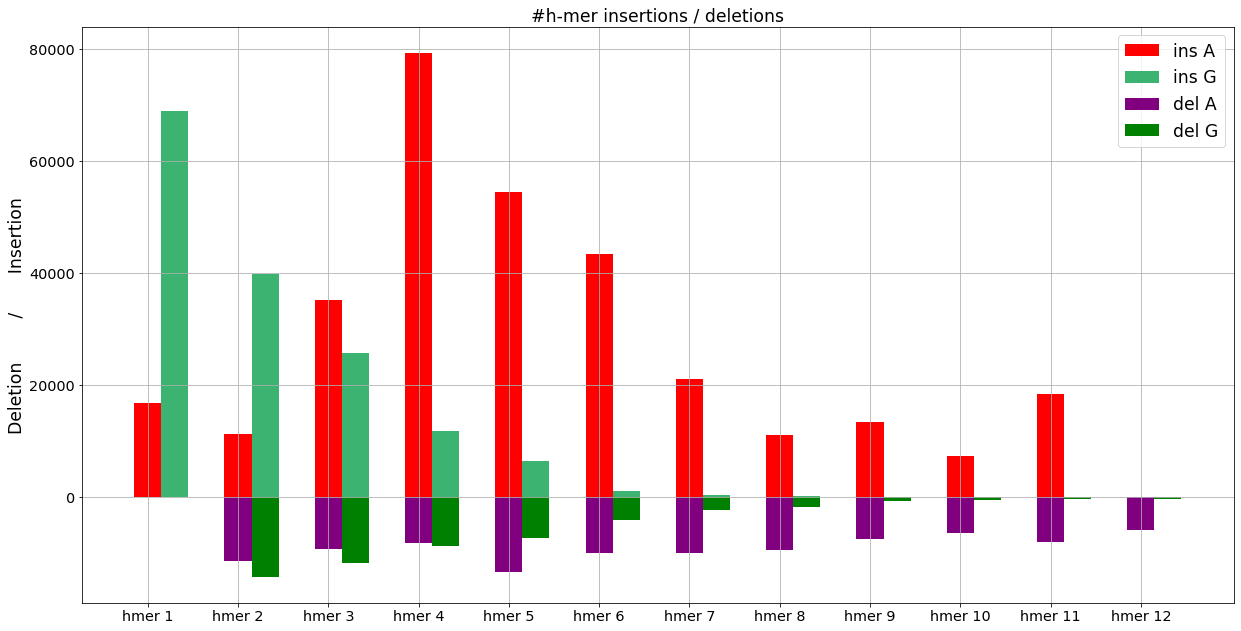

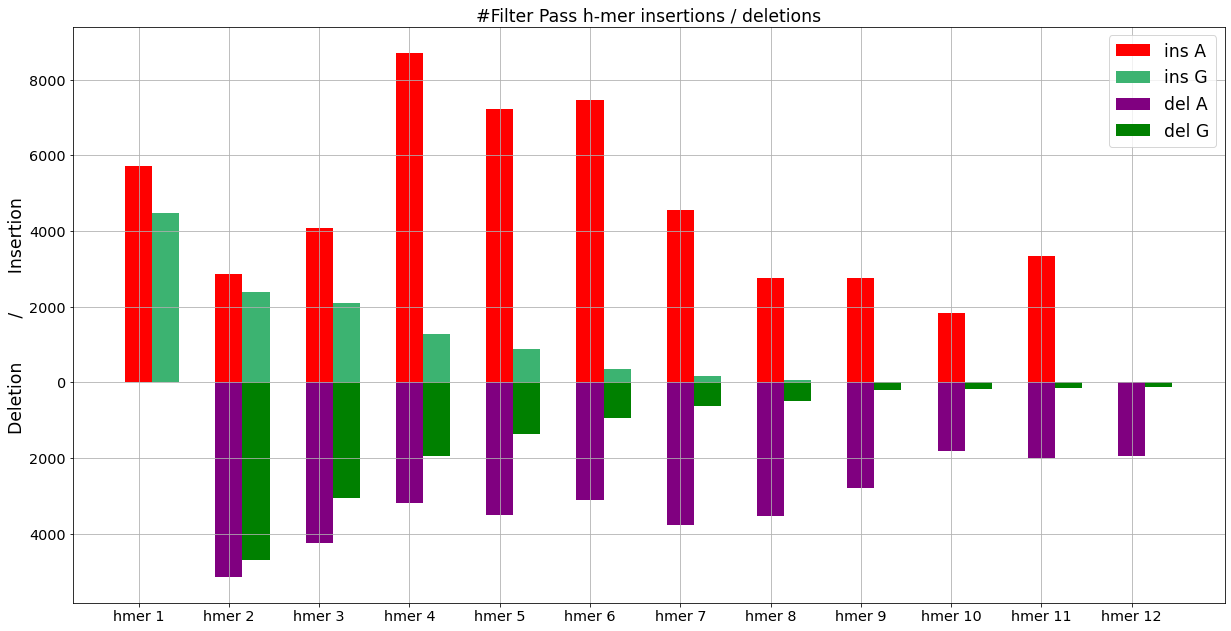

In [53]:
ins_del_hete_graph(ins_del_hete, '#h-mer insertions / deletions')
ins_del_hete_graph(filtered_ins_del_hete, '#Filter Pass h-mer insertions / deletions')

In [37]:
if not is_somatic:
    display(Markdown("""## Homozygous
    """))

In [55]:
if not is_somatic:
    ins_del_hete_graph(ins_del_homo, '# insertions / deletions')
    ins_del_hete_graph(filtered_ins_del_homo, '#Filter Pass insertions / deletions')